## Семинар 5: "Глубинное обучение, часть 1"

In [1]:
import numpy as np
from sklearn.datasets import fetch_mldata
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.autograd import Variable
%matplotlib inline

На этом семинаре мы попробуем улучшить результаты, полученные на предыдущем занятии
Для этого нам понадобятся следующие вещи:
* Dropout
* Batch Normalization
* Инициализация весов

### Часть 1: Инициализация весов

На лекции доказывалось, что при инициализации He и Glorot дисперсия активаций градиентов в каждом слое будут примерно равны. Давайте проверим это. 

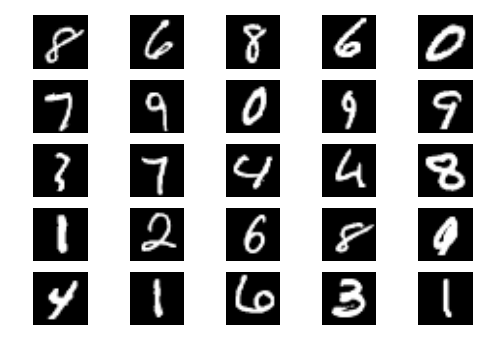

In [2]:
# обратите внимание, что данные имеют размерость examples x channels x w x h
mnist = fetch_mldata('MNIST original')
images = mnist['data']
images = images.reshape(images.shape[0], 1, 28, 28)
labels = mnist['target'].astype(int)
np.random.seed(777)
images_train, images_test, labels_train, labels_test = train_test_split(images, labels)
for i in xrange(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(images_train[i, 0, :, :], cmap=plt.cm.Greys_r)
    plt.axis('off')

images_train_t = torch.from_numpy(images_train).type(torch.cuda.FloatTensor)
images_test_t = torch.from_numpy(images_test).type(torch.cuda.FloatTensor)
labels_train_t = torch.from_numpy(labels_train)
labels_test_t = torch.from_numpy(labels_test)

<i> 1.1 </i> Инициализируйте полносвязную сеть нормальным шумом N(0, 0.1) с архитектурой 784 -> 500 -> 500 -> 300 -> 50 -> 10. В качестве активации возьмите сигмоиду

In [3]:
def init_layer(layer, mean=0, std=1):
    # Тут надо быть аккуратным — можно случайно создать копию и менять значения у копии
    weight = layer.state_dict()['weight']
    bias = layer.state_dict()['bias']
    bias.zero_()
    weight.normal_(mean=0, std=1)

def forward_hook(self, input_, output):
    std = input_[0].std().data[0]
    print 'forward\t\t', type(self), std

def backward_hook(self, grad_input, grad_output):
    std = grad_input[1].std().data[0]
    print 'backward\t', type(self), std

In [9]:
network = nn.Sequential(nn.Linear(28*28, 500),
                        nn.Sigmoid(),
                        nn.Linear(500, 300),
                        nn.Sigmoid(),
                        nn.Linear(300, 50),
                        nn.Sigmoid(),
                        nn.Linear(50, 10))

In [10]:
def init_weights(network, initializer):
    for layer in network:
        if layer.state_dict().keys() != []:
            layer.register_forward_hook(forward_hook)
            layer.register_backward_hook(backward_hook)
            initializer(layer)

In [11]:
init_weights(network, init_layer)

<i>1.2 Пропустите батч изображений через нейронную сеть и вычислите дисперсию активаций. Затем вычислите градиент и получите дисперсию градиентов. Сравните эти значения между собой для разных слоев.</i>

In [12]:
def run(model):
    n_objects = 100
    X = Variable(images_train_t[:n_objects], requires_grad=False).view(n_objects, -1)
    y = Variable(labels_train_t[:n_objects], requires_grad=False)
    activations = model(X)
    loss_fn = torch.nn.NLLLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=0.001) 
    loss = loss_fn(activations, y)
    loss.backward()
    optimizer.step()

<i>1.3 Повторите эксперимент для инициализаций He и Xavier (формулы есть в лекции).</i>

In [13]:
def init_layer_Xavier(layer):
    weight = layer.state_dict()['weight']
    bias = layer.state_dict()['bias']
    bias.zero_()
    weight.uniform_(- np.sqrt(6. / (layer.in_features + layer.out_features)), 
                    + np.sqrt(6. / (layer.in_features + layer.out_features)))
    #weight.normal_(mean = 0., std = np.sqrt(2. / (layer.in_features + layer.out_features)))

In [14]:
network2 = nn.Sequential(nn.Linear(28*28, 500),
                        nn.Sigmoid(),
                        nn.Linear(500, 300),
                        nn.Sigmoid(),
                        nn.Linear(300, 50),
                        nn.Sigmoid(),
                        nn.Linear(50, 10))

In [15]:
init_weights(network2, init_layer_Xavier)

In [16]:
def init_layer_He(layer):
    weight = layer.state_dict()['weight']
    bias = layer.state_dict()['bias']
    bias.zero_()
    weight.normal_(mean=0, std= np.sqrt(2. / layer.in_features))

In [17]:
network3 = nn.Sequential(nn.Linear(28*28, 500),
                        nn.Sigmoid(),
                        nn.Linear(500, 300),
                        nn.Sigmoid(),
                        nn.Linear(300, 50),
                        nn.Sigmoid(),
                        nn.Linear(50, 10))

In [18]:
init_weights(network3, init_layer_He)

In [19]:
print 'Dumb init, sigmoid', '='*60
run(network)
print 'Xavier init, sigmoid', '='*60
run(network2)
print 'He init, sigmoid', '='*60
run(network3)

Dumb init, sigmoid ============================================================
forward		<class 'torch.nn.modules.linear.Linear'> 77.6175994873
forward		<class 'torch.nn.modules.linear.Linear'> 0.49950838089
forward		<class 'torch.nn.modules.linear.Linear'> 0.475004255772
forward		<class 'torch.nn.modules.linear.Linear'> 0.46349683404
backward	<class 'torch.nn.modules.linear.Linear'> 0.0406612530351
backward	<class 'torch.nn.modules.linear.Linear'> 0.0118052465841
backward	<class 'torch.nn.modules.linear.Linear'> 0.00324415368959
backward	<class 'torch.nn.modules.linear.Linear'> 0.0265518147498
Xavier init, sigmoid ============================================================
forward		<class 'torch.nn.modules.linear.Linear'> 77.6175994873
forward		<class 'torch.nn.modules.linear.Linear'> 0.495055824518
forward		<class 'torch.nn.modules.linear.Linear'> 0.166222035885
forward		<class 'torch.nn.modules.linear.Linear'> 0.148919090629
backward	<class 'torch.nn.modules.linear.Linear'> 0.01939

In [20]:
del network, network2, network3
network = nn.Sequential(nn.Linear(28*28, 500),
                        nn.Tanh(),
                        nn.Linear(500, 300),
                        nn.Tanh(),
                        nn.Linear(300, 50),
                        nn.Tanh(),
                        nn.Linear(50, 10))
network2 = nn.Sequential(nn.Linear(28*28, 500),
                        nn.Tanh(),
                        nn.Linear(500, 300),
                        nn.Tanh(),
                        nn.Linear(300, 50),
                        nn.Tanh(),
                        nn.Linear(50, 10))
network3 = nn.Sequential(nn.Linear(28*28, 500),
                        nn.Tanh(),
                        nn.Linear(500, 300),
                        nn.Tanh(),
                        nn.Linear(300, 50),
                        nn.Tanh(),
                        nn.Linear(50, 10))

init_weights(network, init_layer)
init_weights(network2, init_layer_Xavier)
init_weights(network3, init_layer_He)

In [21]:
print 'Dumb init, Tanh', '='*60
run(network)
print 'Xavier init, Tanh', '='*60
run(network2)
print 'He init, Tanh', '='*60
run(network3)

Dumb init, Tanh ============================================================
forward		<class 'torch.nn.modules.linear.Linear'> 77.6175994873
forward		<class 'torch.nn.modules.linear.Linear'> 0.999686062336
forward		<class 'torch.nn.modules.linear.Linear'> 0.981576025486
forward		<class 'torch.nn.modules.linear.Linear'> 0.975904107094
backward	<class 'torch.nn.modules.linear.Linear'> 0.049339029938
backward	<class 'torch.nn.modules.linear.Linear'> 0.0168182365596
backward	<class 'torch.nn.modules.linear.Linear'> 0.0171781238168
backward	<class 'torch.nn.modules.linear.Linear'> 0.394740194082
Xavier init, Tanh ============================================================
forward		<class 'torch.nn.modules.linear.Linear'> 77.6175994873
forward		<class 'torch.nn.modules.linear.Linear'> 0.995361864567
forward		<class 'torch.nn.modules.linear.Linear'> 0.653720319271
forward		<class 'torch.nn.modules.linear.Linear'> 0.580243945122
backward	<class 'torch.nn.modules.linear.Linear'> 0.035067930817

In [22]:
del network, network2, network3
network = nn.Sequential(nn.Linear(28*28, 500),
                        nn.ReLU(),
                        nn.Linear(500, 300),
                        nn.ReLU(),
                        nn.Linear(300, 50),
                        nn.ReLU(),
                        nn.Linear(50, 10))
network2 = nn.Sequential(nn.Linear(28*28, 500),
                        nn.ReLU(),
                        nn.Linear(500, 300),
                        nn.ReLU(),
                        nn.Linear(300, 50),
                        nn.ReLU(),
                        nn.Linear(50, 10))
network3 = nn.Sequential(nn.Linear(28*28, 500),
                        nn.ReLU(),
                        nn.Linear(500, 300),
                        nn.ReLU(),
                        nn.Linear(300, 50),
                        nn.ReLU(),
                        nn.Linear(50, 10))

init_weights(network, init_layer)
init_weights(network2, init_layer_Xavier)
init_weights(network3, init_layer_He)

In [23]:
print 'Dumb init, ReLU', '='*60
run(network)
print 'Xavier init, ReLU', '='*60
run(network2)
print 'He init, ReLU', '='*60
run(network3)

Dumb init, ReLU ============================================================
forward		<class 'torch.nn.modules.linear.Linear'> 77.6175994873
forward		<class 'torch.nn.modules.linear.Linear'> 1355.0723877
forward		<class 'torch.nn.modules.linear.Linear'> 20891.5449219
forward		<class 'torch.nn.modules.linear.Linear'> 265779.65625
backward	<class 'torch.nn.modules.linear.Linear'> 23001.4199219
backward	<class 'torch.nn.modules.linear.Linear'> 3167.76293945
backward	<class 'torch.nn.modules.linear.Linear'> 905.163879395
backward	<class 'torch.nn.modules.linear.Linear'> 488.206207275
Xavier init, ReLU ============================================================
forward		<class 'torch.nn.modules.linear.Linear'> 77.6175994873
forward		<class 'torch.nn.modules.linear.Linear'> 55.1031341553
forward		<class 'torch.nn.modules.linear.Linear'> 43.8957710266
forward		<class 'torch.nn.modules.linear.Linear'> 48.4394340515
backward	<class 'torch.nn.modules.linear.Linear'> 4.36162137985
backward	<clas

<i> 1.4 Сделайте выводы по первой части </i>

### Часть 2: Dropout

Другим полезным слоем является Dropout. В нем с вероятностью 1-p зануляется выход каждого нейрона. Этот слой уже реализован в pyTorch, поэтому вновь реализовывать его не интересно. Давайте реализуем DropConnect — аналог Dropout. В нем с вероятностью 1-p зануляется каждый вес слоя.

<i> 2.1 Реализуйте линейный слой с DropConnect </i>

In [4]:
# полезная функция: .bernoulli_(p)
# не забывайте делать requires_grad=False у маски
# помните, что в вычислениях должны участвовать Variable, а не тензоры
# не забывайте, что в pyTorch нету broadcasting (делайте .repeat)

class DropConnect(nn.Module):
    def __init__(self, input_dim, output_dim, p):
        super(DropConnect, self).__init__()
        self.weight = torch.nn.Parameter(torch.Tensor(input_dim, output_dim).normal_(mean=0, std=0.01), requires_grad=True)
        self.bias = torch.nn.Parameter(torch.Tensor(1, output_dim).zero_(), requires_grad=True)
        self.p = p

    def forward(self, x):
        mask_p = np.ones(self.weight.size()) * self.p
        mask_p = torch.from_numpy(mask_p).type(torch.cuda.FloatTensor)
        mask_b = Variable(data = mask_p.bernoulli_().type(torch.cuda.FloatTensor), requires_grad=False)
        masked_weight = self.weight * mask_b
        output = torch.mm(x, masked_weight) + self.bias.expand(x.size()[0], masked_weight.size()[1])
        return output

<i> 
2.2 Сравните графики обучения нейроных сетей:
1. 784 -> 200 -> 200 -> 10 с сигмоидами и Dropout между всеми слоями 
2. 784 -> 200 -> 200 -> 10 с сигмоидами DropConnect вместо всех линейных слоев
</i>

In [5]:
network_easy = nn.Sequential(nn.Linear(784, 200),
                             nn.Sigmoid(),
                             nn.Linear(200, 200),
                             nn.Sigmoid(),
                             nn.Linear(200, 10),
                             nn.LogSoftmax())

network_dropout = nn.Sequential(nn.Linear(784, 200),
                                nn.Dropout(0.4),
                                nn.Sigmoid(),
                                nn.Linear(200, 200),
                                nn.Dropout(0.4),
                                nn.Sigmoid(),
                                nn.Linear(200, 10),
                                nn.LogSoftmax())

network_dropconnect = nn.Sequential(DropConnect(784, 200, 0.4),
                                    nn.Sigmoid(),
                                    DropConnect(200, 200, 0.4),
                                    nn.Sigmoid(),
                                    DropConnect(200, 10, 0.4),
                                    nn.LogSoftmax())

In [6]:
import pickle as pkl
with open('data.pkl', 'rb') as f:
    data = pkl.load(f)
    X = data['X']
    y = data['y']
    del data
    print X.shape, y.shape

(70000, 784) (70000, 10)


In [7]:
images_train = images_train.reshape((images_train.shape[0], 784))
images_test = images_test.reshape((images_test.shape[0], 784))
images_train_t = torch.from_numpy(images_train).type(torch.cuda.FloatTensor)
images_test_t = torch.from_numpy(images_test).type(torch.cuda.FloatTensor)
labels_train_t = torch.from_numpy(labels_train)
labels_test_t = torch.from_numpy(labels_test)

In [8]:
batch_size = 10
from sklearn.utils import shuffle
from tqdm import tqdm
dtype = torch.cuda.FloatTensor

def train_network(network, loss_type='NLL', n_epochs=10, batch_size=10, opt_type='SGD', lr=0.001, verbose=1, 
                 l2_coeff=0.):
    
    n_batches = images_train.shape[0] / batch_size
    if loss_type == 'NLL': loss_fn = torch.nn.NLLLoss()
    if opt_type == 'Adam': optimizer = torch.optim.Adam(network.parameters(), lr=lr, weight_decay=l2_coeff)
    elif opt_type == 'SGD' : optimizer = torch.optim.SGD(network.parameters(), lr=lr, weight_decay=l2_coeff)
    loss_avg = 0
    losses = []

    for epoch in xrange(n_epochs):

        X_train, Y_train = shuffle(images_train, labels_train)
        x_train = Variable(torch.from_numpy(X_train).type(dtype), requires_grad = False)
        y_train = Variable(torch.from_numpy(Y_train).type(dtype), requires_grad = False)

        for batch in tqdm(xrange(n_batches)):
            x = Variable(torch.from_numpy(X_train[batch : batch + batch_size]).type(dtype), requires_grad = False)
            y = Variable(torch.from_numpy(Y_train[batch : batch + batch_size]).type(torch.cuda.LongTensor), requires_grad = False)
        
            y_pred = network.forward(x)
            loss = loss_fn(input = y_pred, target = y)
            loss_avg += loss.data[0]
        
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        
        losses.append(loss_avg / batch_size)
        
        if verbose: print ("%d, %.4f" % (epoch, loss_avg / batch_size))#, acc_test))
        loss_avg = 0
    return network, losses

In [9]:
network_easy, loss_easy = train_network(network_easy)

100%|██████████| 5250/5250 [00:21<00:00, 241.67it/s]


0, 1110.7335


100%|██████████| 5250/5250 [00:25<00:00, 203.68it/s]


1, 836.2448


100%|██████████| 5250/5250 [00:26<00:00, 195.97it/s]


2, 563.0280


100%|██████████| 5250/5250 [00:29<00:00, 175.76it/s]


3, 389.9587


100%|██████████| 5250/5250 [00:27<00:00, 192.57it/s]


4, 290.3742


100%|██████████| 5250/5250 [00:26<00:00, 195.86it/s]


5, 238.7248


100%|██████████| 5250/5250 [00:26<00:00, 195.00it/s]


6, 204.4954


100%|██████████| 5250/5250 [00:23<00:00, 219.23it/s]


7, 183.0473


100%|██████████| 5250/5250 [00:24<00:00, 213.14it/s]


8, 166.6586


100%|██████████| 5250/5250 [00:24<00:00, 210.47it/s]

9, 157.2006


In [10]:
loss_easy

[1110.733480334282,
 836.2448497056961,
 563.0279924422503,
 389.9587228268385,
 290.3742483228445,
 238.7248234644532,
 204.49541259855033,
 183.0472743500024,
 166.65856014452874,
 157.20056115575136]

In [9]:
# CUDA
network_easy, loss_easy = train_network(network_easy)

  0%|          | 0/5250 [00:00<?, ?it/s]


TypeError: addmm_ received an invalid combination of arguments - got (int, int, torch.cuda.FloatTensor, torch.FloatTensor), but expected one of:
 * (torch.cuda.FloatTensor mat1, torch.cuda.FloatTensor mat2)
 * (torch.cuda.sparse.FloatTensor mat1, torch.cuda.FloatTensor mat2)
 * (float beta, torch.cuda.FloatTensor mat1, torch.cuda.FloatTensor mat2)
 * (float alpha, torch.cuda.FloatTensor mat1, torch.cuda.FloatTensor mat2)
 * (float beta, torch.cuda.sparse.FloatTensor mat1, torch.cuda.FloatTensor mat2)
 * (float alpha, torch.cuda.sparse.FloatTensor mat1, torch.cuda.FloatTensor mat2)
 * (float beta, float alpha, torch.cuda.FloatTensor mat1, torch.cuda.FloatTensor mat2)
 * (float beta, float alpha, torch.cuda.sparse.FloatTensor mat1, torch.cuda.FloatTensor mat2)


In [11]:
network_dropout, loss_dropout = train_network(network_dropout, n_epochs=25) # увеличим число эпох в ~ 1 / 0.4 раз

100%|██████████| 5250/5250 [00:26<00:00, 196.13it/s]


0, 1177.7481


100%|██████████| 5250/5250 [00:25<00:00, 204.68it/s]


1, 1106.6278


100%|██████████| 5250/5250 [00:27<00:00, 188.13it/s]


2, 975.6580


100%|██████████| 5250/5250 [00:28<00:00, 186.91it/s]


3, 808.0371


100%|██████████| 5250/5250 [00:34<00:00, 150.68it/s]


4, 652.6247


100%|██████████| 5250/5250 [00:27<00:00, 193.30it/s]


5, 535.6514


100%|██████████| 5250/5250 [00:22<00:00, 233.71it/s]


6, 442.6297


100%|██████████| 5250/5250 [00:23<00:00, 219.40it/s]


7, 384.3519


100%|██████████| 5250/5250 [00:25<00:00, 240.40it/s]


8, 333.3130


100%|██████████| 5250/5250 [00:33<00:00, 179.62it/s]


9, 302.7177


100%|██████████| 5250/5250 [00:21<00:00, 239.07it/s]


10, 269.7663


100%|██████████| 5250/5250 [00:22<00:00, 237.08it/s]


11, 253.3944


100%|██████████| 5250/5250 [00:23<00:00, 225.19it/s]


12, 237.1173


100%|██████████| 5250/5250 [00:22<00:00, 229.16it/s]


13, 228.6728


100%|██████████| 5250/5250 [00:25<00:00, 206.15it/s]


14, 212.8616


100%|██████████| 5250/5250 [00:23<00:00, 219.70it/s]


15, 199.9248


100%|██████████| 5250/5250 [00:25<00:00, 201.93it/s]


16, 197.8040


100%|██████████| 5250/5250 [00:25<00:00, 202.05it/s]


17, 184.2696


100%|██████████| 5250/5250 [00:26<00:00, 197.13it/s]


18, 196.3039


100%|██████████| 5250/5250 [00:26<00:00, 201.03it/s]


19, 184.9303


100%|██████████| 5250/5250 [00:23<00:00, 248.38it/s]


20, 182.7618


100%|██████████| 5250/5250 [00:20<00:00, 256.71it/s]


21, 180.7455


100%|██████████| 5250/5250 [00:21<00:00, 246.56it/s]


22, 166.5272


100%|██████████| 5250/5250 [00:22<00:00, 232.25it/s]


23, 175.1559


100%|██████████| 5250/5250 [00:23<00:00, 223.68it/s]

24, 164.5812


In [12]:
loss_dropout

[1177.7481211662293,
 1106.6278046131133,
 975.657960820198,
 808.0371134638787,
 652.624723136425,
 535.6514326006175,
 442.6297229111195,
 384.3518684923649,
 333.3130421638489,
 302.71766796261073,
 269.76627753525975,
 253.39443700686098,
 237.11725969538094,
 228.67280832454563,
 212.8615779131651,
 199.9247590020299,
 197.80396800786258,
 184.2695906162262,
 196.30387776009738,
 184.93027034066617,
 182.7617969855666,
 180.74546629860998,
 166.52715580854564,
 175.1559144206345,
 164.58123650252818]

In [39]:
network_dropconnect, loss_dropconnect = train_network(network_dropconnect, opt_type='Adam', n_epochs=25) 


  3%|▎         | 165/5250 [00:03<01:47, 47.15it/s]

100%|██████████| 5250/5250 [02:36<00:00, 32.89it/s]


0, 454.3793


100%|██████████| 5250/5250 [01:54<00:00, 42.66it/s]


1, 269.8207


100%|██████████| 5250/5250 [01:58<00:00, 44.36it/s]


2, 222.3350


100%|██████████| 5250/5250 [02:15<00:00, 38.69it/s]


3, 198.5490


100%|██████████| 5250/5250 [02:00<00:00, 45.80it/s]


4, 190.4298


  0%|          | 0/5250 [00:00<?, ?it/s]

5, 168.3497


100%|██████████| 5250/5250 [01:40<00:00, 52.19it/s]


6, 171.6105


  0%|          | 0/5250 [00:00<?, ?it/s]

7, 163.4729


100%|██████████| 5250/5250 [01:45<00:00, 49.73it/s]


8, 155.2131


  0%|          | 0/5250 [00:00<?, ?it/s]

9, 154.3474


  0%|          | 0/5250 [00:00<?, ?it/s]

10, 144.2934


  0%|          | 0/5250 [00:00<?, ?it/s]

11, 147.2897


  0%|          | 0/5250 [00:00<?, ?it/s]

12, 144.4243


  0%|          | 0/5250 [00:00<?, ?it/s]

13, 145.7327


  0%|          | 0/5250 [00:00<?, ?it/s]

14, 138.2964


  0%|          | 0/5250 [00:00<?, ?it/s]

15, 132.7220


  0%|          | 0/5250 [00:00<?, ?it/s]

16, 143.3993


  0%|          | 0/5250 [00:00<?, ?it/s]

17, 131.4622


  0%|          | 0/5250 [00:00<?, ?it/s]

18, 136.9428


100%|██████████| 5250/5250 [02:07<00:00, 22.11it/s]


19, 135.8323


  0%|          | 0/5250 [00:00<?, ?it/s]

20, 125.9995


  0%|          | 0/5250 [00:00<?, ?it/s]

21, 125.7638


  0%|          | 0/5250 [00:00<?, ?it/s]

22, 124.3830


  0%|          | 0/5250 [00:00<?, ?it/s]

23, 132.3086


100%|██████████| 5250/5250 [02:09<00:00, 43.07it/s]

24, 131.2219


In [40]:
loss_dropconnect

[454.37932080812755,
 269.82067378014324,
 222.3349727164954,
 198.54897105870768,
 190.4297944287071,
 168.34968172926455,
 171.61045726588927,
 163.47287196044346,
 155.21307991326321,
 154.3473749249475,
 144.29335081662285,
 147.28966923943955,
 144.42428219201975,
 145.73271909465547,
 138.29643771901027,
 132.72201925546398,
 143.3992968523293,
 131.46216225834797,
 136.94275253335945,
 135.83234513443895,
 125.99952334841946,
 125.76382065756479,
 124.38300390783698,
 132.30858412891394,
 131.22189899313963]

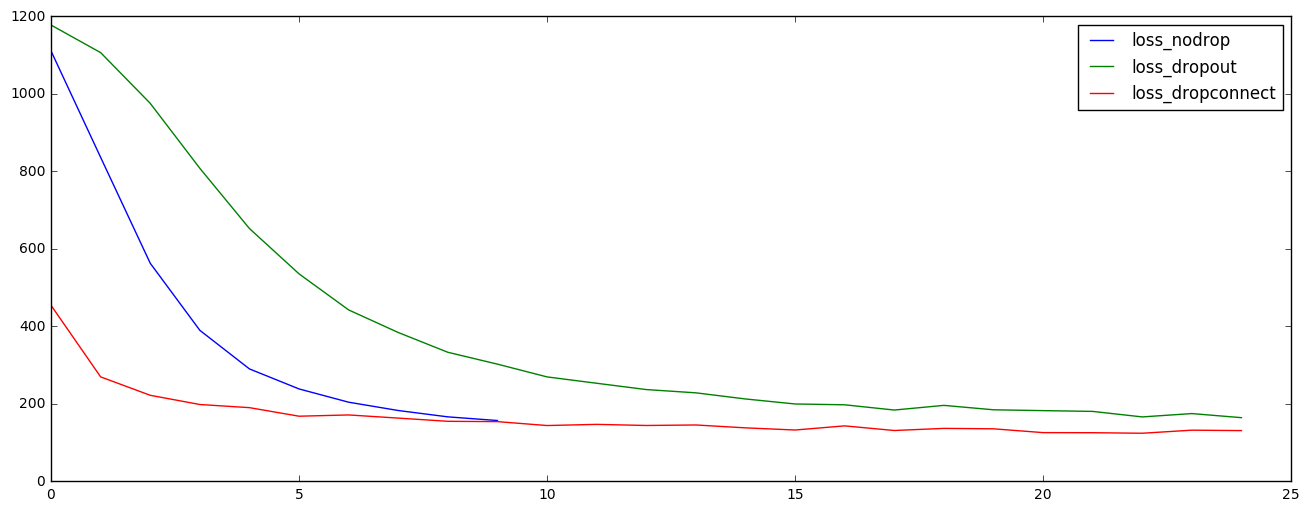

In [41]:
plt.figure(figsize=(16,6))
plt.plot(loss_easy, label = 'loss_nodrop')
plt.plot(loss_dropout, label = 'loss_dropout')
plt.plot(loss_dropconnect, label = 'loss_dropconnect')
plt.legend()
plt.show()

<i> 2.3 Сделайте выводы по второй части </i>

В test-time стохастичность Dropout убирают и заменяют все веса на их ожидаемое значение: $\mathbb{E}w = pw + (1-p)0 = pw$.

### Часть 3: Batch Normalization

Наконец, давайте рассмотрим Batch Normalization. Этот слой вычитает среднее и делит на стандартное отклонение. Среднее и дисперсия вычисляются по батчу независимо для каждого нейрона. У этого слоя есть две важные проблемы: его нельзя использовать при обучении с размером батча 1 и он делает элементы батча зависимыми. Давайте реализуем аналог батч нормализации: <a href=https://arxiv.org/pdf/1607.06450.pdf>Layer normalization</a>. В layer normalization среднее и дисперсия вычисляются по активациям нейронов, независимо для каждого объекта.

<i> 3.1 Реализуйте Layer Normalization </i>

In [136]:
# полезные функции: .std(dim), .mean(dim)
# не забывайте, что в pyTorch нету broadcasting (делайте .repeat)

class LayerNormalization(nn.Module):
    def forward(self, x):
        mean_layer = x.mean(1)
        std_layer = x.std(1)
        output = (x - mean_layer.expand(x.size())) / std_layer.expand(x.size())
        return output

<i> 
3.2 Сравните графики обучения нейроных сетей:
1. 784 -> 200 -> 200 -> 10 с сигмоидами и Batch normalization между всеми слоями 
2. 784 -> 200 -> 200 -> 10 с сигмоидами и Layer normalization между всеми слоями 
</i>

In [137]:
network_wBN = nn.Sequential(nn.Linear(784, 200, bias=False),
                            nn.BatchNorm1d(200),
                            nn.Sigmoid(),
                            nn.Linear(200, 200, bias=False),
                            nn.BatchNorm1d(200),
                            nn.Sigmoid(),
                            nn.Linear(200, 10, bias=False),
                            nn.BatchNorm1d(10),
                            nn.LogSoftmax())

network_wLN = nn.Sequential(nn.Linear(784, 200, bias=False),
                            LayerNormalization(),
                            nn.Sigmoid(),
                            nn.Linear(200, 200, bias=False),
                            LayerNormalization(),
                            nn.Sigmoid(),
                            nn.Linear(200, 10, bias=False),
                            LayerNormalization(),
                            nn.LogSoftmax())

In [117]:
network_wBN, loss_wBN = train_network(network_wBN, lr=0.01)


 56%|█████▋    | 2955/5250 [00:40<00:31, 73.80it/s]

  0%|          | 0/5250 [00:00<?, ?it/s]

0, 360.7707


  0%|          | 0/5250 [00:00<?, ?it/s]

1, 242.9767


  0%|          | 0/5250 [00:00<?, ?it/s]

2, 204.8066


  0%|          | 0/5250 [00:00<?, ?it/s]

3, 171.7376


100%|██████████| 5250/5250 [00:49<00:00, 106.63it/s]

4, 155.9659


In [138]:
network_wLN, loss_wLN = train_network(network_wLN, lr=0.01)

100%|██████████| 5250/5250 [01:13<00:00, 95.24it/s]


0, 540.7682


  0%|          | 0/5250 [00:00<?, ?it/s]

1, 374.9583


  0%|          | 0/5250 [00:00<?, ?it/s]

2, 331.4677


  0%|          | 0/5250 [00:00<?, ?it/s]

3, 320.7365


100%|██████████| 5250/5250 [01:12<00:00, 83.26it/s]

4, 303.4134


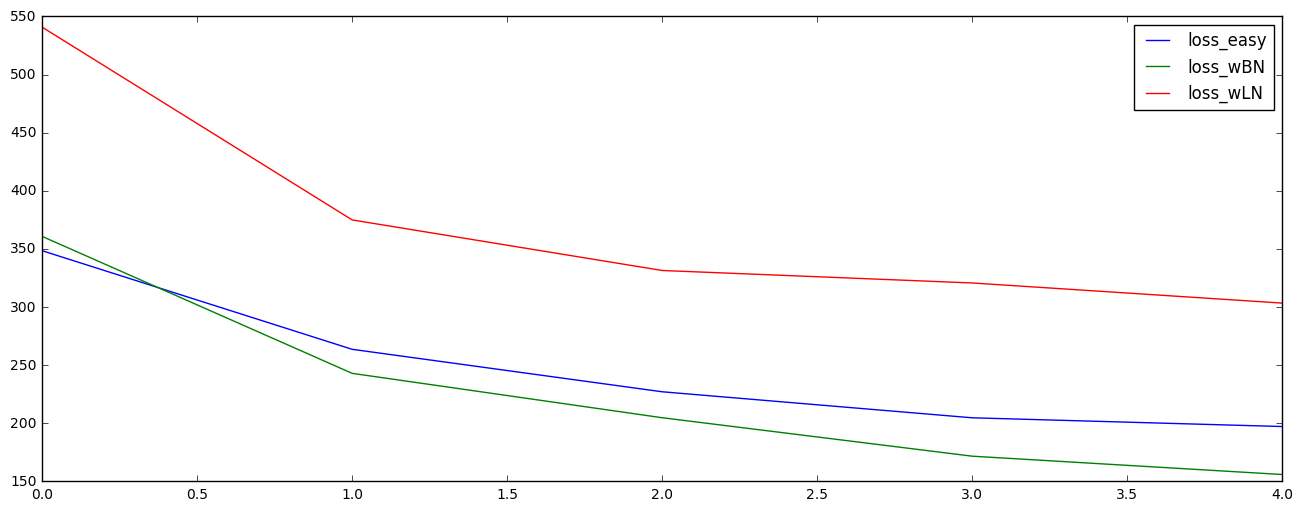

In [140]:
plt.figure(figsize=(16,6))
plt.plot(loss_easy, label = 'loss_easy')
plt.plot(loss_wBN, label = 'loss_wBN')
plt.plot(loss_wLN, label = 'loss_wLN')
plt.legend()
plt.show()

<i> 3.3 Сделайте выводы по третьей части </i>

#### Feedback (опционально)

Здесь вы можете оставить список опечаток из лекции или семинара:

Здесь вы можете оставить комментарии по лекции или семинару: